In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow.keras.datasets as datasets
from torch_dataload import MyDataset
import nn_fuzzy
import matplotlib.pyplot as plt

In [2]:
#Parameters - To be defined by user
nClass = 10
nHidden = [256]
nInput = 784
layers = [nInput] + nHidden + [nClass]
limit = 0.0001
#Hyperparameters - To be tuned by the user
learning_rate = 0.01
nMiniBatch = 128
nIter = 10000
print("Layers: ", layers)
print("Learning Rate: ", learning_rate)
print("Number of MiniBatch: ", nMiniBatch)
print("Iterations: ", nIter)

#Parameters (for fuzzy)- To be defined by user
nClass_fuzzy = 10
nHidden_fuzzy = [256]
nInput_fuzzy = 784 * 3
layers_fuzzy = [nInput_fuzzy] + nHidden_fuzzy + [nClass_fuzzy]
limit = 0.0001
#Hyperparameters - To be tuned by the user
learning_rate = 0.01
nMiniBatch = 128
nIter = 10000
print("Layers: ", layers_fuzzy)
print("Learning Rate: ", learning_rate)
print("Number of MiniBatch: ", nMiniBatch)
print("Iterations: ", nIter)

#Parameters (for heart)- To be defined by user
nClass_heart = 2
nHidden_heart = [8]
nInput_heart = 13 * 3
layers_heart = [nInput_heart] + nHidden_heart + [nClass_heart]
limit = 0.0001
#Hyperparameters - To be tuned by the user
learning_rate = 0.01
nMiniBatch = 16
nIter = 10000
print("Layers: ", layers_heart)
print("Learning Rate: ", learning_rate)
print("Number of MiniBatch: ", nMiniBatch)
print("Iterations: ", nIter)

Layers:  [784, 256, 10]
Learning Rate:  0.01
Number of MiniBatch:  128
Iterations:  10000
Layers:  [2352, 256, 10]
Learning Rate:  0.01
Number of MiniBatch:  128
Iterations:  10000
Layers:  [39, 8, 2]
Learning Rate:  0.01
Number of MiniBatch:  16
Iterations:  10000


In [3]:
#-------data input function-----------------------------#
def getDataset(name, nClass):
    if name=="mnist":
        dataset = datasets.mnist
    (x_train, y_train),(x_test, y_test) = dataset.load_data()     #downloading and loading the dataset
    x_train, x_test = x_train / 255.0, x_test / 255.0             #normalizing the input data
    x_train_flat = x_train.reshape(x_train.shape[0],-1)         #making dataset suitable for input in Fully Connected layer
    x_test_flat = x_test.reshape(x_test.shape[0],-1)          #making dataset suitable for input in Fully Connected layer
    y_train_onehot = np.eye(nClass)[y_train]                    #converting to one hot vectors
    y_test_onehot = np.eye(nClass)[y_test]                     #converting to one hot vectors
    print(x_train_flat.shape)
    print(y_train_onehot.shape)
    x_train_batch = np.array_split(x_train_flat, int(60000/128))
    print(x_train_batch[2].shape)
    return x_train_flat,x_test_flat,y_train_onehot,y_test_onehot

x_train, x_test, y_train, y_test = getDataset("mnist", 10)

(60000, 784)
(60000, 10)
(129, 784)


In [4]:
x_train_fuzzy, x_test_fuzzy, y_train_fuzzy, y_test_fuzzy = nn_fuzzy.fuzzify_dataset(x_train, x_test, y_train, y_test, cnn=1)

Time taken to fuzzify - x_train : 128.53146409988403
Time taken to fuzzify - x_test : 15.26023554801941
(10, 784)
(10, 784)
Time taken to fuzzify - y_train : 6.7653467655181885
Time taken to fuzzify - y_train : 2.384185791015625e-07


In [5]:
x_train_fuzzy.shape

(60000, 3, 784)

In [6]:
x_train_fuzzy = x_train_fuzzy.reshape(60000, 3, 28, 28)
x_test_fuzzy = x_test_fuzzy.reshape(10000, 3, 28, 28)

In [7]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

array([0.02338903, 0.00144004, 0.0749184 , 0.02306003, 0.00747646,
       0.04009882, 0.0127191 , 0.00315317, 0.03124792, 0.00361206])

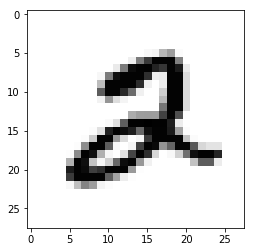

In [8]:
index = 5
plt.imshow(x_train[index].reshape(28,28), cmap='Greys')
y_train_fuzzy[index]

array([0.02338903, 0.00144004, 0.0749184 , 0.02306003, 0.00747646,
       0.04009882, 0.0127191 , 0.00315317, 0.03124792, 0.00361206])

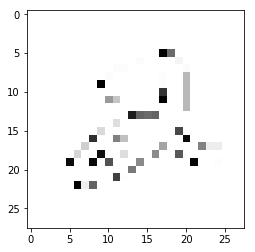

In [9]:
plt.imshow(x_train_fuzzy[index][0].reshape(28,28), cmap='Greys')
y_train_fuzzy[index]

array([1.25418435e-01, 3.16540276e-04, 3.24934009e-02, 2.34406898e-02,
       1.59187933e-02, 3.22759307e-02, 1.30781527e-02, 2.49335401e-07,
       3.02577342e-02, 6.42767310e-03])

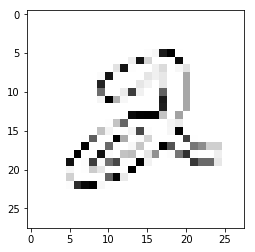

In [10]:
plt.imshow(x_train_fuzzy[index][1].reshape(28,28), cmap='Greys')
y_train_fuzzy[1]

array([1.25418435e-01, 3.16540276e-04, 3.24934009e-02, 2.34406898e-02,
       1.59187933e-02, 3.22759307e-02, 1.30781527e-02, 2.49335401e-07,
       3.02577342e-02, 6.42767310e-03])

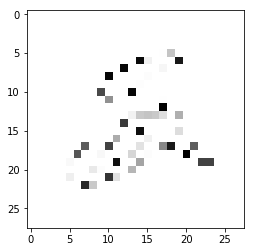

In [11]:
plt.imshow(x_train_fuzzy[index][2].reshape(28,28), cmap='Greys')
y_train_fuzzy[1]

In [ ]:
# trainset = MyDataset(x_train, x_test, y_train, y_test, train=True)
trainset = MyDataset(x_train, x_test, y_train, y_test, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)

# testset = MyDataset(x_train, x_test, y_train, y_test, train=False)
testset = MyDataset(x_train, x_test, y_train, y_test, train=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
net = Net()

In [ ]:
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        _, labels =  torch.max(labels,1)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))